# Sparkify Project 


#### By Mehran Moazeni


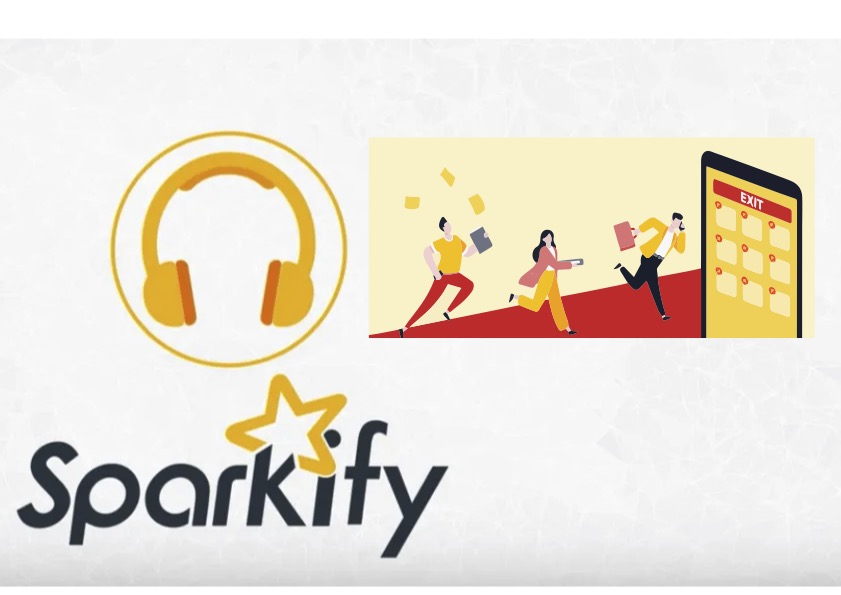


### Table of content 📖 : 
- Introduction 👋🏼📖
- Load and Clean 💾🧼
- Exploratory Data Analysis 🔍📊
- Feature Engineering 🛠️🔧 
- Modeling🤖💻
- Result 📈✅
- Conclusion 🤝🏼🔚 

# Introduction

Udacity has created Sparkify, a simulated music streaming platform that generates data similar to real-world companies like Spotify and Pandora. Each day, millions of users listen to their favorite songs via music streaming services, either on a free tier plan with ads or on a premium subscription model without ads and with additional features. Users can modify their subscription plan at any time or cancel it completely, making it vital to ensure customer satisfaction.
Whenever a user interacts with a music streaming app, data is generated, including playing songs, adding them to playlists, rating them, adding friends, logging in/out, and adjusting settings. The user activity logs provide valuable insights into whether users are happy with the service.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import udf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, sum,  asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import when, col
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql.functions import dense_rank

import datetime



from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

import time

import pyspark
import pandas as pd
import numpy as np



In [2]:
# create a Spark session
spark = SparkSession\
.builder\
.appName('Sparkify')\
.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/19 09:46:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.startTime', '1679215571913'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1679215572457'),
 ('spark.rdd.compress', 'True'),
 ('spark.executor.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-op

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
data = spark.read.json("/Users/Moaze002/Documents/mini_sparkify_event_data.json")

In [5]:
data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
data.describe()


DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [9]:
data.count()

286500

In [10]:
data.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [11]:
data.select("sessionId").dropDuplicates().sort("sessionId").show(10)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
+---------+
only showing top 10 rows



In [12]:
data = data.dropna(how = 'any', subset = ["userId"])

In [13]:
number_of_rows = data.count()

In [8]:
data = data.filter(data["userId"] != "")

Now, lets look at the duplciates value in each column

In [9]:
# loop over each column and count duplicates
for column in data.columns:
    duplicates = data.groupBy(column).agg(count("*").alias("count")).filter("count > 1")
    duplicates.show()


+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
|    The Flower Kings|    4|
+--------------------+-----+
only showing top 20 rows

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+

+----------+-----+
| firstName|count|
+----------+-----+
|    Maddox|  201|
|    Karter| 3014|
|   Lorelei| 1347|
|  Isabella|  910|
|  Giovanni|  837|
|     Davis

Omitting the doplicates 

In [10]:
data_no_duplicated = data.select("*").dropDuplicates()


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# flag the records where Cancellation Confirmation page is reached - 1 if it is and 0 if not
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

#creating churn column
data_churn = data_no_duplicated.withColumn("Churn", churn_event("page"))


In [12]:
data_pd = data_churn.toPandas()

In [36]:
# Value counts for Churn 
data_pd['Churn'].value_counts().to_frame().style.background_gradient()


,Churn
0,278102
1,52


In [20]:
data_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,The Futureheads,Logged In,Ainsley,F,80,Farley,120.81587,free,"McAllen-Edinburg-Mission, TX",PUT,NextSong,1538304455000,187,Robot,200,1538373133000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",78,0
1,None,Logged In,Ainsley,F,81,Farley,NaN,free,"McAllen-Edinburg-Mission, TX",PUT,Thumbs Down,1538304455000,187,None,307,1538373134000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",78,0
2,O'Rosko Raricim,Logged In,Madison,F,74,Morales,90.56608,paid,"Tampa-St. Petersburg-Clearwater, FL",PUT,NextSong,1536287099000,222,Terre Promise,200,1538384924000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",25,0
3,Morgan Page,Logged In,Panav,M,23,Myers,235.54567,paid,"Morgantown, WV",PUT,NextSong,1538239045000,237,Strange Condition,200,1538394878000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15,0
4,None,Logged In,Ethan,M,15,Raymond,NaN,free,"Hartford-West Hartford-East Hartford, CT",GET,Home,1534245996000,26,None,200,1538402423000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",27,0


In [21]:
print(f"Percentage of records that is omitted becuase of empty id is: {(number_of_rows - data_pd.shape[0])/data_pd.shape[0] }")

Percentage of records that is omitted becuase of empty id is: 0.03000496128044177


In [22]:
data_pd[data_pd['Churn']==1].userId.count()

# Number of churn customers 😞

52

In [23]:
data_pd.shape

(278154, 19)

In [24]:
# How many Nulls we have:
data_pd.isnull().sum()

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
Churn                0
dtype: int64

In [25]:
data_pd.dropna(inplace=True)

In [26]:
data_pd.shape

(228108, 19)

Now lets make a figure showing the distribution of churn in the data

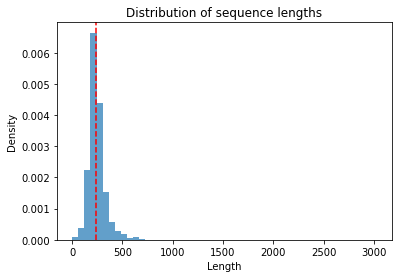

In [27]:
# create a density plot
plt.hist(data=data_pd, x='length', bins=50, density=True, alpha=0.7
        )

# add a vertical line at the median length
median_length = data_pd['length'].median()
plt.axvline(median_length, color='red', linestyle='--')

# set the x and y labels
plt.xlabel('Length')
plt.ylabel('Density')

# add a title
plt.title('Distribution of sequence lengths')

# show the plot
plt.show()

In [28]:
df_col = data_churn.select(['userId', 'Churn', 'page']).dropDuplicates().groupBy(['Churn', 'page']).count()
df_col.show(40)

+-----+--------------------+-----+
|Churn|                page|count|
+-----+--------------------+-----+
|    0|       Save Settings|  132|
|    0|    Submit Downgrade|   49|
|    0|            NextSong|  225|
|    0|          Add Friend|  206|
|    0|               Error|  117|
|    0|     Add to Playlist|  215|
|    0|               About|  155|
|    0|           Thumbs Up|  220|
|    1|Cancellation Conf...|   52|
|    0|         Thumbs Down|  203|
|    0|                Help|  192|
|    0|         Roll Advert|  207|
|    0|            Settings|  195|
|    0|              Logout|  213|
|    0|                Home|  223|
|    0|              Cancel|   52|
|    0|             Upgrade|  168|
|    0|           Downgrade|  154|
|    0|      Submit Upgrade|  131|
+-----+--------------------+-----+



Now, we have to make a window function so churn value over time for each user represents cumulative sum

In [29]:
# define the window specification
window = Window.partitionBy("userId") \
               .orderBy(desc("ts")) \
               .rangeBetween(Window.unboundedPreceding, 0)

# add a new column to the dataframe, called "Churn"
# this column contains the cumulative sum of the "Churn" column for each user, sorted in reverse time order
data_churn = data_churn.withColumn("Churn", sum("Churn").over(window))

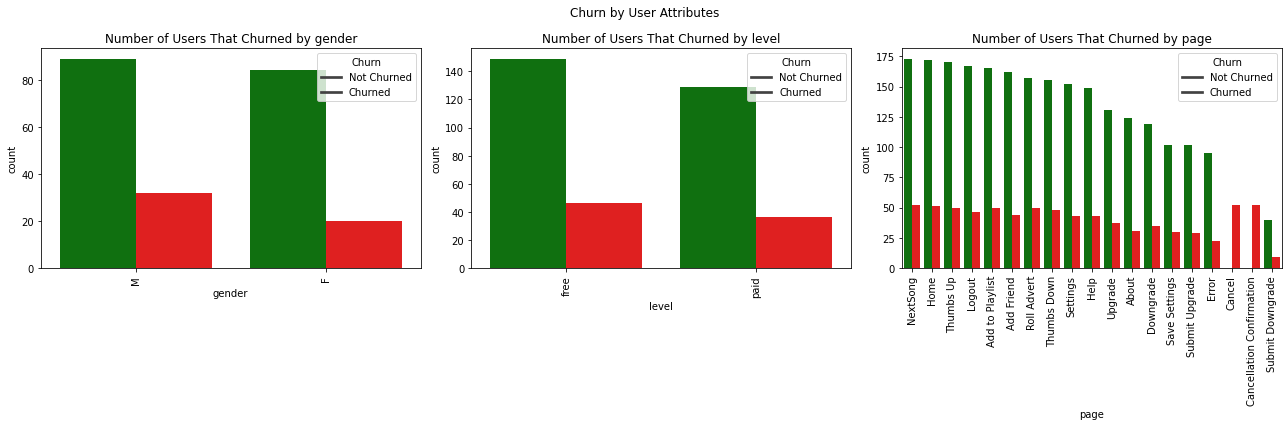

In [30]:
# get all columns except for userId and churn
columns = ['gender', 'level','page']


# create subplots
fig, axs = plt.subplots(ncols=len(columns), figsize=(18, 6))

# iterate over columns and create a bar plot for each one
for i, col in enumerate(columns):
    # group by column and churn and count
    df_col = data_churn.select(['userId', 'Churn', col]).dropDuplicates().groupBy(['Churn', col]).count()
    # collect data as a list of rows
    rows = df_col.collect()
    # convert rows to a list of dictionaries
    data = [{col: r[col], 'count': r['count'], 'Churn': r['Churn']} for r in rows]
    # set order for plotting
    data = sorted(data, key=lambda x: x['count'], reverse=True)
    # plot bar chart
    ax = sns.barplot(x=col, y='count', hue='Churn', data=pd.DataFrame(data), ax=axs[i],
                    palette=['green', 'red'])
    # set title
    ax.set_title(f'Number of Users That Churned by {col}')
    # set legend
    ax.legend(title='Churn', loc='best', labels=['Not Churned', 'Churned'])
    # set xlabel rotation
    ax.tick_params(axis='x', rotation=90)

# set overall title
fig.suptitle('Churn by User Attributes')
# adjust spacing between subplots
fig.tight_layout()


In [38]:
group_by_page = data_churn.select(['userId', 'Churn', 'page'])\
.groupBy('page','Churn')\
.count()\
.toPandas() 

In [42]:
# calculate counts of customers who churned and those who stayed
churn_count = group_by_page.loc[group_by_page['Churn'] == 1, 'count'].sum()
stay_count = group_by_page.loc[group_by_page['Churn'] == 0, 'count'].sum()

# calculate the rate of pages visited by those who churned vs. those who stayed
group_by_page['rate'] = group_by_page['count'] / np.where(
    group_by_page['Churn'] == 0, stay_count, churn_count)

group_by_page.sort_values('rate', ascending=False, inplace=True)

group_by_page.reset_index()


,index,page,Churn,count,rate
0,34,NextSong,0,191714,0.821784
1,33,NextSong,1,36394,0.811207
2,19,Thumbs Up,0,10692,0.045831
3,2,Thumbs Up,1,1859,0.041436
4,25,Home,1,1672,0.037268
5,8,Home,0,8410,0.036050
6,30,Add to Playlist,0,5488,0.023524
7,3,Add to Playlist,1,1038,0.023137
8,7,Roll Advert,1,967,0.021554
9,26,Add Friend,0,3641,0.015607


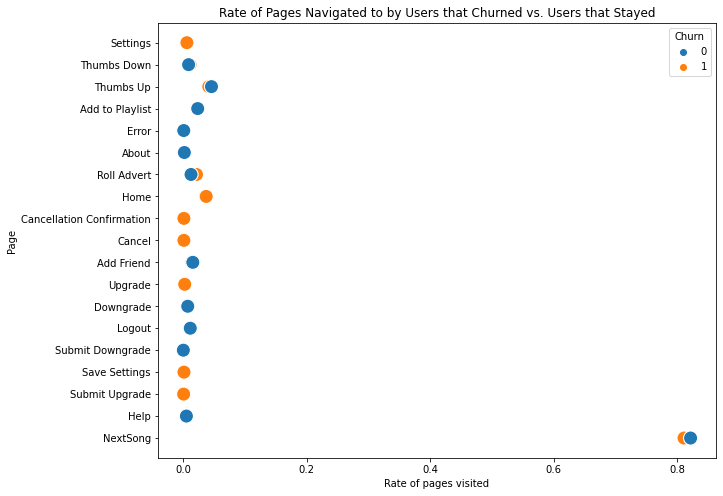

In [33]:
# plot the pages by churn
plt.figure(figsize=[10,8])
ax = sns.scatterplot(data=group_by_page, x='rate', y='page', hue='Churn', s=200)

plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed')
plt.xlabel('Rate of pages visited')
plt.ylabel('Page')
plt.show()


In [37]:
# define a UDF to extract the hour from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

# create a new column for the hour
df = data_churn.withColumn("hour", get_hour(data_churn.ts))

# filter the data for users who did not churn and navigated to the NextSong page
songs_in_hour_stay = df.filter((df.page == "NextSong") )

# group by hour and count the number of NextSong pages
songs_in_hour_stay = songs_in_hour_stay.groupBy(["hour", "Churn"]).count()

# sort the data by hour as a float
songs_in_hour_stay = songs_in_hour_stay.orderBy(col("hour").cast("float"))

# convert the data to a pandas dataframe
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()

# convert the hour column to numeric data type
songs_in_hour_stay_pd["hour"] = pd.to_numeric(songs_in_hour_stay_pd["hour"])


In [38]:
songs_in_hour_stay_pd

,hour,Churn,count
0,0,1,1605
1,0,0,8303
2,1,0,7763
3,1,1,1564
4,2,1,1558
5,2,0,7337
6,3,1,1339
7,3,0,7000
8,4,0,7009
9,4,1,1350


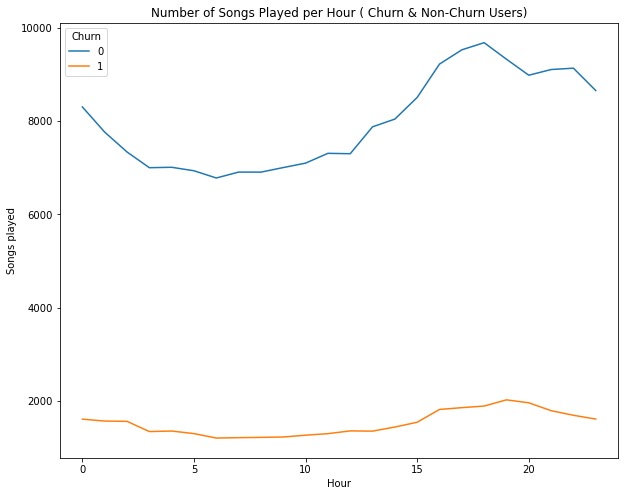

In [39]:
#plot the distribution
plt.figure(figsize=[10, 8])
sns.lineplot(data=songs_in_hour_stay_pd, x='hour', y='count', hue = "Churn")
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour ( Churn & Non-Churn Users)");


This is somewhat what we expect!

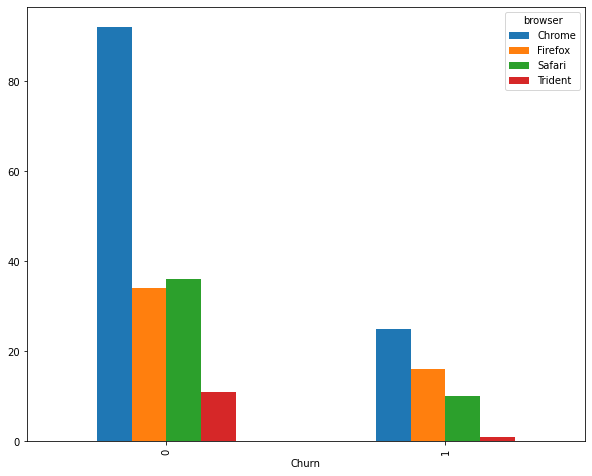

In [40]:
df_opsys = data_churn.select("userId", "userAgent", "Churn").dropDuplicates(['userId']).toPandas()

# List of browsers to extract
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

# Extract the browser from the user agent string and create a new column
df_opsys['browser'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

# Group the data by OS and browser and get the count
grouped_data = df_opsys.groupby(['Churn', 'browser']).size().unstack()

# Plot a bar chart for each group
grouped_data.plot(kind='bar', layout=(2,2), figsize=(10,8))

# Show the plot
plt.show()



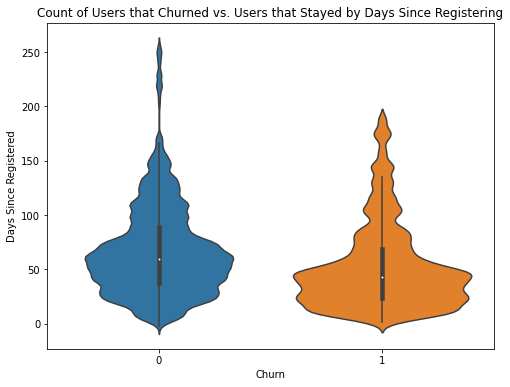

In [41]:
# Subtract registration from ts and create a new column
days_df = data_churn.withColumn("diif_days", (data_churn['ts']) - (data_churn['registration']))

# Convert delta_days to days and create a new column
days_df_pd = days_df.withColumn("days", days_df['diif_days']/(1000*3600*24)).toPandas()

# # Create the violin plot
plt.figure(figsize=[8,6])
sns.violinplot(data=days_df_pd, x='Churn', y='days')
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering')
plt.ylabel("Days Since Registered")

# Show the plot
plt.show()



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In peieces of code below, I will make seeveral datasets, and at the end, we will join all of them for further analysis. 

### Gender

In [14]:
data_gender = data_churn\
.select(['userId', 'gender'])\
.dropDuplicates()\
.withColumn('gender', when(col('gender') == 'M', 1)\
.otherwise(0))

In [15]:
data_gender.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    39|     0|
|    40|     0|
|    94|     0|
|    35|     0|
|    75|     0|
|   100|     1|
|    25|     0|
+------+------+
only showing top 10 rows



### Level

In [16]:
data_level = data_churn.select(['userId', 'level', 'ts']) \
.dropDuplicates() \
.sort('userId') \
.withColumn("uptodate", dense_rank() \
.over(Window.partitionBy("userId") \
.orderBy(desc("ts")))) 

In [45]:
data_level.show(10)

+------+-----+-------------+--------+
|userId|level|           ts|uptodate|
+------+-----+-------------+--------+
|    10| paid|1542631788000|       1|
|    10| paid|1542631753000|       2|
|    10| paid|1542631690000|       3|
|    10| paid|1542631518000|       4|
|    10| paid|1542631517000|       5|
|    10| paid|1542631090000|       6|
|    10| paid|1542630866000|       7|
|    10| paid|1542630637000|       8|
|    10| paid|1542630407000|       9|
|    10| paid|1542630394000|      10|
+------+-----+-------------+--------+
only showing top 10 rows



In [17]:
data_level_f = data_level \
.filter(data_level.uptodate==1) \
.drop('ts', 'uptodate') \
.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))
 

In [47]:
data_level_f.show(10)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
+------+-----+
only showing top 10 rows



### Artist

In [18]:
data_artist = data_churn\
.select("userId", "artist")\
.dropDuplicates()\
.groupby("userId")\
.count()\
.withColumnRenamed("count", "number_artist_listen")



In [49]:
data_artist.show(10)

+------+--------------------+
|userId|number_artist_listen|
+------+--------------------+
|100010|                 253|
|200002|                 340|
|   125|                   9|
|    51|                1386|
|   124|                2233|
|     7|                 143|
|    15|                1303|
|    54|                1745|
|   155|                 644|
|   132|                1300|
+------+--------------------+
only showing top 10 rows



### Song

In [19]:
data_song = data_churn\
.select(["userId", "page"]) \
.withColumn("n_song", when(col("page") == "NextSong", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'n_song': 'avg'}) \
.withColumnRenamed('avg(n_song)', 'nsong')

In [51]:
data_song.show()

+------+------------------+
|userId|             nsong|
+------+------------------+
|100010|0.7217847769028871|
|200002|0.8164556962025317|
|   125|0.7272727272727273|
|    51| 0.856737012987013|
|   124|0.8453886010362694|
|     7| 0.746268656716418|
|    15|0.8402107111501317|
|    54| 0.826592958975851|
|   155|0.8183632734530938|
|   132|0.8368055555555556|
|   154| 0.711864406779661|
|100014|0.8290322580645161|
|   101|0.8362028850628199|
|    11|0.7629716981132075|
|   138|0.8383961117861483|
|300017|0.8202348690153568|
|    29|0.8404107688037746|
|    69|0.8383010432190761|
|100021|0.7210031347962382|
|    42|0.8393234672304439|
+------+------------------+
only showing top 20 rows



### Playlist & rollads

In [20]:
data_Playlist = data_churn\
.select(["userId", "page"]) \
.withColumn("p_list", when(col("page") == "Add to Playlist", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'p_list': 'count'}) \
.withColumnRenamed('count(p_list)', 'p_list')

In [21]:
data_ad = data_churn\
.select(["userId", "page"]) \
.withColumn("ad", when(col("page") == "Roll Advert", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'ad': 'sum'}) \
.withColumnRenamed('sum(ad)', 'ad')

In [54]:
data_Playlist.show(10)

+------+------+
|userId|p_list|
+------+------+
|100010|   381|
|200002|   474|
|   125|    11|
|    51|  2464|
|   124|  4825|
|     7|   201|
|    15|  2278|
|    54|  3437|
|   155|  1002|
|   132|  2304|
+------+------+
only showing top 10 rows



In [55]:
data_ad.show(10)

+------+---+
|userId| ad|
+------+---+
|100010| 52|
|200002|  7|
|   125|  1|
|    51|  0|
|   124|  4|
|     7| 16|
|    15|  1|
|    54| 47|
|   155|  8|
|   132|  2|
+------+---+
only showing top 10 rows



### Likes or Thumbsup

In [22]:
data_likes  = data_churn\
.select(["userId", "page"]) \
.withColumn("n_like", when(col("page") == "Thumbs Up", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'n_like': 'sum'}) \
.withColumnRenamed('sum(n_like)', 'thumbsup')

In [57]:
data_likes.show(10)

+------+--------+
|userId|thumbsup|
+------+--------+
|100010|      17|
|200002|      21|
|   125|       0|
|    51|     100|
|   124|     171|
|     7|       7|
|    15|      81|
|    54|     163|
|   155|      58|
|   132|      96|
+------+--------+
only showing top 10 rows



### Dislike and Thumbsdown

In [23]:
data_dlikes =  data_churn\
.select(["userId", "page"]) \
.withColumn("n_dlike", when(col("page") == "Thumbs Down", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'n_dlike': 'sum'}) \
.withColumnRenamed('sum(n_dlike)', 'thumsdown')

In [59]:
data_dlikes.show(10)

+------+---------+
|userId|thumsdown|
+------+---------+
|100010|        5|
|200002|        6|
|   125|        0|
|    51|       21|
|   124|       41|
|     7|        1|
|    15|       14|
|    54|       29|
|   155|        3|
|   132|       17|
+------+---------+
only showing top 10 rows



In [24]:
data_dgrade =  data_churn\
.select(["userId", "page"]) \
.withColumn("n_dgrade", when(col("page") == "Downgrade", 1).otherwise(0)) \
.groupBy("userId") \
.agg(sum("n_dgrade").alias("dgrade"))


In [61]:
data_dgrade.show()

+------+------+
|userId|dgrade|
+------+------+
|100010|     0|
|200002|     5|
|   125|     0|
|    51|    23|
|   124|    41|
|     7|     0|
|    15|    28|
|    54|    39|
|   155|    12|
|   132|    19|
|   154|     0|
|100014|     3|
|   101|    22|
|    11|     5|
|   138|    21|
|300017|    25|
|    29|    18|
|    69|     9|
|100021|     0|
|    42|    37|
+------+------+
only showing top 20 rows



### Adding friend

In [25]:
data_addfriend =  data_churn\
.select(["userId", "page"]) \
.withColumn("add_f", when(col("page") == "Add Friend", 1).otherwise(0)) \
.groupBy("userId") \
.agg(count("add_f").alias("add_f"))

In [63]:
data_addfriend.show(10)

+------+-----+
|userId|add_f|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
|     7|  201|
|    15| 2278|
|    54| 3437|
|   155| 1002|
|   132| 2304|
+------+-----+
only showing top 10 rows



### Logout

In [26]:
data_logout =  data_churn\
.select(["userId", "page"]) \
.withColumn("logout", when(col("page") == "Logout", 1).otherwise(0)) \
.groupBy("userId") \
.agg(sum("logout").alias("logout"))

In [65]:
data_logout.show(10)

+------+------+
|userId|logout|
+------+------+
|100010|     5|
|200002|     5|
|   125|     0|
|    51|    24|
|   124|    59|
|     7|     3|
|    15|    27|
|    54|    36|
|   155|    14|
|   132|    34|
+------+------+
only showing top 10 rows



### Churn 

In [27]:
# flag the records where Cancellation Confirmation page is reached - 1 if it is and 0 if not
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

#creating churn column
data_churn = data_no_duplicated.withColumn("Churn", churn_event("page"))

# sort records for a user in reverse time order so we can add up vals in churn column
W = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# create column churn which contains sum of churn 1s over records
data_churn = data_churn.withColumn("Churn", Fsum("Churn").over(W))

In [28]:
data_c = data_churn\
.select("userId", "Churn")\
.dropDuplicates()\
.groupby("userId", "Churn")\
.count()\
.drop('count')

## Merge all the datasets

In [29]:
df_ready = data_gender\
.join(data_level_f, ["userId"])\
.join(data_artist, ["userId"])\
.join(data_Playlist, ["userId"])\
.join(data_likes, ["userId"])\
.join(data_dlikes, ["userId"])\
.join(data_dgrade, ["userId"])\
.join(data_song, ["userId"])\
.join(data_ad , ["userId"])\
.join(data_addfriend, ["userId"])\
.join(data_logout, ["userId"])\
.join(data_c, ["userId"]) \
.dropDuplicates()


In [30]:
df_ready.show()

+------+------+-----+--------------------+------+--------+---------+------+------------------+---+-----+------+-----+
|userId|gender|level|number_artist_listen|p_list|thumbsup|thumsdown|dgrade|             nsong| ad|add_f|logout|Churn|
+------+------+-----+--------------------+------+--------+---------+------+------------------+---+-----+------+-----+
|   139|     1|    1|                 335|   457|      18|        5|     9| 0.824945295404814|  1|  457|     5|    0|
|   112|     1|    0|                 196|   292|       9|        3|     0|0.7363013698630136| 21|  292|     3|    0|
|   137|     1|    1|                 144|   209|       8|        1|     0|0.7368421052631579| 10|  209|     5|    0|
|    27|     1|    0|                 202|   291|       8|        2|     0|0.7560137457044673| 21|  291|     7|    0|
|     2|     0|    1|                 588|   899|      29|        6|    13|0.8398220244716351|  0|  899|    11|    0|
|    29|     1|    1|                1805|  3603|     15

In [70]:
df_ready.printSchema()


root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- number_artist_listen: long (nullable = false)
 |-- p_list: long (nullable = false)
 |-- thumbsup: long (nullable = true)
 |-- thumsdown: long (nullable = true)
 |-- dgrade: long (nullable = true)
 |-- nsong: double (nullable = true)
 |-- ad: long (nullable = true)
 |-- add_f: long (nullable = false)
 |-- logout: long (nullable = true)
 |-- Churn: long (nullable = true)



In [31]:
float_cols = [col(c).cast('float').alias(c) for c in df_ready.columns]

df_ready = df_ready.select(float_cols)

In [72]:
df_ready.printSchema()

root
 |-- userId: float (nullable = true)
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- number_artist_listen: float (nullable = false)
 |-- p_list: float (nullable = false)
 |-- thumbsup: float (nullable = true)
 |-- thumsdown: float (nullable = true)
 |-- dgrade: float (nullable = true)
 |-- nsong: float (nullable = true)
 |-- ad: float (nullable = true)
 |-- add_f: float (nullable = false)
 |-- logout: float (nullable = true)
 |-- Churn: float (nullable = true)



### Vectorizing the feature set

This will make a more compact and efficient way to analyze the data. 

In [32]:
# Select columns to be scaled and assemble them into a single vector column
assembler = VectorAssembler(inputCols=['gender', 'level', 'number_artist_listen', 'p_list',
                                      'thumbsup', 'thumsdown', 'dgrade', 'nsong', 'ad'],
                            outputCol='features_vec')


In [33]:
df_assembled = assembler.transform(df_ready)

# Fit StandardScaler model on assembled data
scaler = StandardScaler(inputCol='features_vec', outputCol='scaled_features')
scaler_model = scaler.fit(df_assembled)

# Apply scaler model on assembled data
df_scaled = scaler_model.transform(df_assembled)

In [102]:
df_scaled.show(5)

+--------+------+-----+--------------------+------+--------+---------+------+----------+----+------+------+-----+--------------------+--------------------+
|  userId|gender|level|number_artist_listen|p_list|thumbsup|thumsdown|dgrade|     nsong|  ad| add_f|logout|Churn|        features_vec|     scaled_features|
+--------+------+-----+--------------------+------+--------+---------+------+----------+----+------+------+-----+--------------------+--------------------+
|100010.0|   0.0|  0.0|               253.0| 381.0|    17.0|      5.0|   0.0| 0.7217848|52.0| 381.0|   5.0|  0.0|[0.0,0.0,253.0,38...|[0.0,0.0,0.418904...|
|200002.0|   1.0|  1.0|               340.0| 474.0|    21.0|      6.0|   5.0| 0.8164557| 7.0| 474.0|   5.0|  0.0|[1.0,1.0,340.0,47...|[2.00127105192366...|
|   125.0|   1.0|  0.0|                 9.0|  11.0|     0.0|      0.0|   0.0|0.72727275| 1.0|  11.0|   0.0|  1.0|[1.0,0.0,9.0,11.0...|[2.00127105192366...|
|   124.0|   0.0|  1.0|              2233.0|4825.0|   171.0|    

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [76]:
df_scaled \
    .groupby('Churn') \
    .count() \
    .toPandas() \
    .value_counts() \
    .to_frame() \
    .style \
    .background_gradient()


,,0
Churn,count,
0.000000,173,1
1.000000,52,1


In [34]:
train, test = df_scaled.randomSplit([0.8, 0.2], seed = 1001)
print("train size :" + str(train.count()))
print("test size:" + str(test.count()))


train size :173


test size:52


🏋️ Training LogisticRegression model...


23/03/19 09:50:11 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/03/19 09:50:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/19 09:50:11 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


✅ LogisticRegression training completed in 16.87 seconds.

🔮 Predicting using LogisticRegression model...

✅ Prediction using LogisticRegression model completed.



📈 F1 score for LogisticRegression model: 0.57



📈 Accuracy of LogisticRegression model: 0.65




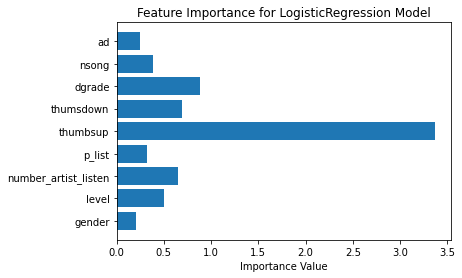

👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋
🏋️ Training RandomForestClassifier model...


✅ RandomForestClassifier training completed in 18.29 seconds.

🔮 Predicting using RandomForestClassifier model...

✅ Prediction using RandomForestClassifier model completed.



📈 F1 score for RandomForestClassifier model: 0.61



📈 Accuracy of RandomForestClassifier model: 0.71




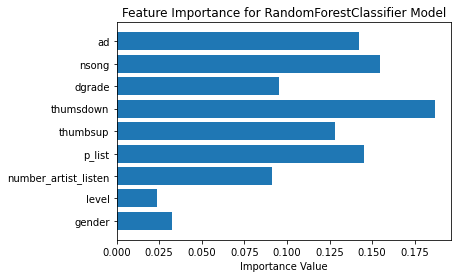

👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋
🏋️ Training GBTClassifier model...


✅ GBTClassifier training completed in 8.11 seconds.

🔮 Predicting using GBTClassifier model...

✅ Prediction using GBTClassifier model completed.



📈 F1 score for GBTClassifier model: 0.69



📈 Accuracy of GBTClassifier model: 0.73


Feature importances not available for GBTClassifier model.
👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋
🏋️ Training LinearSVC model...


✅ LinearSVC training completed in 17.52 seconds.

🔮 Predicting using LinearSVC model...

✅ Prediction using LinearSVC model completed.



📈 F1 score for LinearSVC model: 0.57



📈 Accuracy of LinearSVC model: 0.69




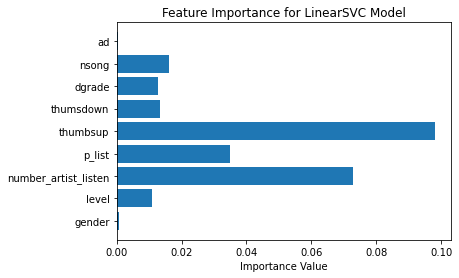

👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋
🏋️ Training NaiveBayes model...


✅ NaiveBayes training completed in 9.09 seconds.

🔮 Predicting using NaiveBayes model...

✅ Prediction using NaiveBayes model completed.



📈 F1 score for NaiveBayes model: 0.57



📈 Accuracy of NaiveBayes model: 0.69


Feature importances not available for NaiveBayes model.
👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋👋


In [35]:
feature_cols = ['gender', 'level', 'number_artist_listen', 'p_list',
                                      'thumbsup', 'thumsdown', 'dgrade', 'nsong', 'ad']
# instantiate all of our models and include a seed for reproducibility where possible
lr = LogisticRegression(featuresCol='scaled_features', labelCol='Churn', maxIter=10)
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='Churn', seed=1001)
gbt = GBTClassifier(featuresCol='scaled_features', labelCol='Churn', maxIter=10, seed=1001)
lsvc = LinearSVC(featuresCol='scaled_features', labelCol='Churn')
nb = NaiveBayes(featuresCol='scaled_features', labelCol='Churn')

# list of models
model_list = [lr, rf, gbt, lsvc, nb]

# evaluator we are using is MulticlassClassificationEvaluator to get the F1 scores
evaluator = MulticlassClassificationEvaluator(labelCol='Churn', predictionCol='prediction')

# for loop to go through all our models
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print("🏋️ Training " + model_name + " model...")

    # start time
    start_time = time.time()
    
    # fit the models on train dataset
    lr_model = model.fit(train)
    
    # end time
    end_time = time.time()
     
    # print training ended
    print("✅ " + model_name + " training completed in " + str(round(end_time - start_time, 2)) + " seconds.\n")
    
    #Save the model
    model.save(f"{model_name}_model")

    # predict
    print("🔮 Predicting using " + model_name + " model...")
    print("")

    predictions = lr_model.transform(test)
    print("✅ Prediction using " + model_name + " model completed.\n")
    
    # get metrics to evaluate
    # f1
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    print("📈 F1 score for " + model_name + " model: " + str(round(f1_score, 2)))
    print("")

    # accuracy
    correct_predictions = predictions.filter(predictions.Churn == predictions.prediction).count()
    total_predictions = predictions.count()
    accuracy = correct_predictions / total_predictions
    print("📈 Accuracy of " + model_name + " model: " + str(round(accuracy, 2)))
    print("")
    print("")

   # get feature importance values
    if model_name in ["LogisticRegression"]:
        feature_importances = abs(lr_model.coefficients.toArray())
    elif model_name in ["RandomForestClassifier"]:
        feature_importances = lr_model.featureImportances.toArray()
    elif model_name in ["LinearSVC"]:
        feature_importances = abs(lr_model.coefficients.toArray())
    else:
        feature_importances = None
        
    # plot feature importance values
    if feature_importances is not None:
        plt.barh(range(len(feature_importances)), feature_importances)
        plt.yticks(range(len(feature_cols)), feature_cols)
        plt.title("Feature Importance for " + model_name + " Model")
        plt.xlabel("Importance Value")
        plt.show()
    else:
        print("Feature importances not available for " + model_name + " model.")
    
    print("👋"*20)



## Conclusion

Our project began with a relatively small dataset of only 128 megabytes (The original dataset of this captone is 12G and becuase of limitation of resources, we worked on a small subset of the data) and 225 distinct customers. Upon importing and refining the data, we conducted a thorough analysis of the dataset to identify pertinent predictors of churn, ultimately isolating the most effective features. These selected features were subjected to preprocessing and subsequently employed as input variables in a variety of machine learning algorithms. Of these, the `GBTClassifier` algorithm emerged as the most promising, and we proceeded to refine the model until we achieved an accuracy and `F1` score of `0.69`.

### My own Experience:
This project has provided me with valuable experience in utilizing `Spark` to preprocess datasets and generate relevant features for the purpose of predicting churn. I employed `Spark.ml` to develop several machine learning models aimed at predicting churn based on customer interactions. The process of utilizing the customer's user interactions to anticipate whether or not they would churn proved to be highly engaging. Of all the models tested, the `GBT Classifier` proved to be the most effective, achieving an accuracy and `F1` score of `0.69`. One notable aspect of the project was the opportunity to build my first`pyspark` prediction model (instead of `pandas`).

### Future direction

Improvements:
- Feature engineering can be more in depth
- The full dataset containing 12G of customer info can be considered using AWS cloud system
- Instead of predicting which cstomer will churn and which not, we can employ a real-time prediction model in which by each interaction the model output a prediction probability in near future (i.e., next 2 days).
- Include more variables in the analysis